In [1]:
import ann_visualizer
import copy
import datetime
from IPython.display import display, Image
import json
import logging
import matplotlib.pyplot as plt
import numpy
import os
import pandas
import pdb
import pickle
import plotly
import pyarrow.parquet as pq
import random
import requests
import six
import slack
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Input, Dropout, BatchNormalization
import time

import CS230

plotly.offline.init_notebook_mode(connected=True)
#tf.enable_eager_execution()

# model 8: LSTM single output

In [2]:
MODEL_NAME = 'model-8'
MODEL_DIR = os.path.join('models', MODEL_NAME)
RESULTS_FILE_PATH = os.path.join(MODEL_DIR, 'results.csv')
EPOCHS = 200
SLACK_WEBHOOK_URL = os.environ['SLACK_WEBHOOK_URL']

logger = CS230.common.get_logger()

In [3]:
#TODO upload image to training error

def slack_post(text, image=None):
    data = {
        'text': datetime.datetime.now().strftime("%H:%M:%S ") + text,
        'username': 'training',
        'icon_emoji': ':robot_face:'
    }
    
    response = requests.post(SLACK_WEBHOOK_URL, data=json.dumps(data), headers={'Content-Type': 'application/json'})
    print('Response: ' + str(response.text))
    print('Response code: ' + str(response.status_code))

# load and format data

In [4]:
FILE_PATHS = []

for dir_path, dir_names, file_names in os.walk(CS230.data.DATA_DIR):
    if dir_path.startswith('.'):
        continue
    
    for file_name in file_names:
        if file_name.endswith('.parquet'):
            file_path = os.path.join(dir_path, file_name)
            FILE_PATHS.append(file_path)
    
    if FILE_PATHS:
        break  # exit after loading files from 1 directory

FILE_PATHS.sort()
FILE_PATHS

['/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140221_01_01_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140221_01_02_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140221_02_01_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140221_03_01_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140221_03_02_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140221_03_03_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140221_04_01_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140222_01_01_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140222

In [5]:
COLS_X = {
    'x1': ['axCG', 'ayCG', 'azCG', 'brake', 'chassisAccelFL', 'chassisAccelFR', 'chassisAccelRL', 'chassisAccelRR', 
          'clutch', 'handwheelAngle', 'deflectionFL', 'deflectionFR',
          'horizontalSpeed', 'pitchAngle', 'pitchRate', 'rollAngle', 'rollRate', 'throttle', 'vxCG', 'vyCG', 'vzCG', 
          'wheelAccelFL', 'wheelAccelFR', 'wheelAccelRL', 'wheelAccelRR', 'yawAngle', 'yawRate'],
    
    'x2': ['brake', 'clutch', 'handwheelAngle', 'throttle',
           'horizontalSpeed', 'pitchAngle', 'pitchRate', 'rollAngle', 'rollRate',
           'vxCG', 'vyCG', 'vzCG', 'yawAngle', 'yawRate'],
    
    'x3': ['brake', 'clutch', 'handwheelAngle', 'throttle',
           'pitchAngle', 'pitchRate', 'rollAngle', 'rollRate', 'yawAngle', 'yawRate',
           'vxCG', 'vyCG', 'vzCG', 'axCG', 'ayCG', 'azCG',
           'wheelAccelFL', 'wheelAccelFR', 'wheelAccelRL', 'wheelAccelRR'],
    
    'x4': ['brake', 'clutch', 'handwheelAngle', 'throttle',
           'pitchAngle', 'pitchRate', 'rollAngle', 'rollRate', 'yawAngle', 'yawRate',
           'vxCG', 'vyCG', 'vzCG', 'axCG', 'ayCG', 'azCG'],
    
    'x5': ['brake', 'clutch', 'handwheelAngle', 'throttle', 'vxCG']
}

COLS_Y = {
    'y1': ['axCG', 'ayCG', 'azCG', 'chassisAccelFL', 'chassisAccelFR', 'chassisAccelRL', 'chassisAccelRR',
          'horizontalSpeed', 'pitchAngle', 'pitchRate', 'rollAngle', 'rollRate', 'vxCG', 'vyCG', 'vzCG',
          'wheelAccelFL', 'wheelAccelFR', 'wheelAccelRL', 'wheelAccelRR', 'yawAngle', 'yawRate'],
    
    'y2': ['pitchAngle', 'rollAngle', 'vxCG', 'vyCG', 'vzCG',
          'wheelAccelFL', 'wheelAccelFR', 'wheelAccelRL', 'wheelAccelRR', 'yawAngle'],
    
    'y3': ['pitchAngle', 'pitchRate', 'rollAngle', 'rollRate', 'yawAngle', 'yawRate',
           'vxCG', 'vyCG', 'vzCG', 'axCG', 'ayCG', 'azCG',
           'wheelAccelFL', 'wheelAccelFR', 'wheelAccelRL', 'wheelAccelRR'],
    
    'y4': ['pitchAngle', 'rollAngle', 'yawAngle',
           'vxCG', 'vyCG', 'vzCG',
           'wheelAccelFL', 'wheelAccelFR', 'wheelAccelRL', 'wheelAccelRR'],
    
    'y5': ['rollAngle', 'yawAngle', 'vxCG', 'vyCG', 'vzCG'],
    
    'y6': ['yawAngle', 'vxCG'],
    
    'y7': ['wheelAccelFL', 'wheelAccelFR', 'wheelAccelRL', 'wheelAccelRR'],
}

In [6]:
for k, v in six.iteritems(COLS_Y):
    print(k)
    print(', '.join(v))

y1
axCG, ayCG, azCG, chassisAccelFL, chassisAccelFR, chassisAccelRL, chassisAccelRR, horizontalSpeed, pitchAngle, pitchRate, rollAngle, rollRate, vxCG, vyCG, vzCG, wheelAccelFL, wheelAccelFR, wheelAccelRL, wheelAccelRR, yawAngle, yawRate
y2
pitchAngle, rollAngle, vxCG, vyCG, vzCG, wheelAccelFL, wheelAccelFR, wheelAccelRL, wheelAccelRR, yawAngle
y3
pitchAngle, pitchRate, rollAngle, rollRate, yawAngle, yawRate, vxCG, vyCG, vzCG, axCG, ayCG, azCG, wheelAccelFL, wheelAccelFR, wheelAccelRL, wheelAccelRR
y4
pitchAngle, rollAngle, yawAngle, vxCG, vyCG, vzCG, wheelAccelFL, wheelAccelFR, wheelAccelRL, wheelAccelRR
y5
rollAngle, yawAngle, vxCG, vyCG, vzCG
y6
yawAngle, vxCG
y7
wheelAccelFL, wheelAccelFR, wheelAccelRL, wheelAccelRR


In [7]:
def get_cols_y(cols_y):
    if isinstance(cols_y, list):
        if cols_y[0] in COLS_Y.keys():
            cols_y = COLS_Y[cols_y[0]]
        else:
            cols_y = cols_y
    else:
        if cols_y in COLS_Y.keys():
            cols_y = COLS_Y[cols_y]
        else:
            cols_y = [cols_y]
    return(cols_y)

In [8]:
def get_df(file_path, cols_x, cols_y):
    cols_all = copy.deepcopy(cols_x)
    cols_all.extend(cols_y)
    cols_all = list(set(cols_all))  # reduce to unique
    
    df = CS230.data.load(file_path)[cols_all]
    df = CS230.data.stride_rows(df, stride=10)
    df.dropna(axis=0, inplace=True)
    
    df_x = copy.deepcopy(df)[cols_x]
    df_x = df_x.iloc[:-1].reset_index(drop=True)
    
    df_y = copy.deepcopy(df)[cols_y]
    df_y = df_y.iloc[1:].reset_index(drop=True)
    
    return df_x, df_y

# get data

In [9]:
data_name = 'train'

In [10]:
def get_data(cols_x, cols_y, sequence_length, num_data_files):
    DATA = {}
    DATA[data_name] = {
        'df': {
            'x': pandas.DataFrame(columns=COLS_X[cols_x]),
            'y': pandas.DataFrame(columns=cols_y)
        }
    }

    for i in range(num_data_files):
        file_path = FILE_PATHS[i]

        df_x, df_y = get_df(file_path, cols_x=COLS_X[cols_x], cols_y=cols_y)
        
        DATA[data_name]['df']['x'] = pandas.concat([DATA[data_name]['df']['x'], df_x], ignore_index=True, sort=False)
        
        DATA[data_name]['df']['y'] = pandas.concat([DATA[data_name]['df']['y'], df_y], ignore_index=True, sort=False)
        
        print(i, DATA[data_name]['df']['x'].shape)
        print(i, DATA[data_name]['df']['y'].shape)

    DATA[data_name]['generator'] = tf.keras.preprocessing.sequence.TimeseriesGenerator(
                                    DATA[data_name]['df']['x'].values,
                                    DATA[data_name]['df']['y'].values,
                                    length=sequence_length, sampling_rate=1  #, shuffle=True
    )
    
    return DATA

# build models

In [11]:
PARAMS = []
for sequence_length in range(100, 200, 10):
    for cols_x in ['x5']:
        for cols_y in ['y7']:
            for learning_rate in [5e-3]:
                for learning_rate_decay in [1e-5, 3e-5, 5e-5]:
                    for batch_norm in [False]:
                        for dropout in [0.1]:
                            for lstm_units in [sequence_length]:
                                for num_data_files in [4]:
                                    params = {
                                        'sequence_length': int(sequence_length),
                                        'cols_x': cols_x,
                                        'cols_y': cols_y,
                                        'learning_rate': float(learning_rate),
                                        'learning_rate_decay': float(learning_rate_decay),
                                        'batch_norm': batch_norm,
                                        'dropout': float(dropout),
                                        'lstm_units': int(lstm_units),
                                        'num_data_files': num_data_files,
                                        '2nd_LSTM_layer': False
                                        }
                                    PARAMS.append(params)

In [12]:
# TODO output sigmoid with multiplier for range
# TODO reduce to 1 output at a time to fully understand what result means
# TODO expand size of input data set
# TODO convert data load from pd.dataframe to np.array

1 from 30
0 (53546, 4)
0 (53546, 4)
1 (132645, 4)
1 (132645, 4)
2 (132645, 4)
2 (132645, 4)


21-02-22 | INFO | models/model-8/20190613210222
21-02-22 | INFO | {'sequence_length': 100, 'cols_x': 'x5', 'cols_y': 'y7', 'learning_rate': 0.005, 'learning_rate_decay': 3e-05, 'batch_norm': False, 'dropout': 0.1, 'lstm_units': 100, 'num_data_files': 4, '2nd_LSTM_layer': False}


3 (132645, 4)
3 (132645, 4)
Response: ok
Response code: 200
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               42000     
_________________________________________________________________
dense (Dense)                (None, 4)                 404       
Total params: 42,404
Trainable params: 42,404
Non-trainable params: 0
_________________________________________________________________


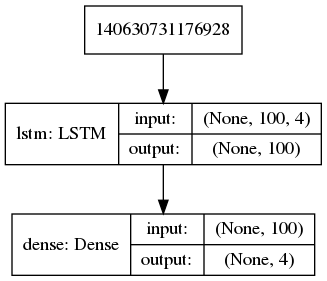

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 530/1036 [==============>...............] - ETA: 42s - loss: 9.4534 - mean_absolute_error: 1.8592

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/dave/venv/py3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-751c5c1bd72f>", line 116, in <module>
    callbacks=callbacks
  File "/home/dave/venv/py3.6/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py", line 1426, in fit_generator
    initial_epoch=initial_epoch)
  File "/home/dave/venv/py3.6/lib/python3.6/site-packages/tensorflow/python/keras/engine/training_generator.py", line 191, in model_iteration
    batch_outs = batch_function(*batch_data)
  File "/home/dave/venv/py3.6/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py", line 1191, in train_on_batch
    outputs = self._fit_function(ins)  # pylint: disable=not-callable
  File "/home/dave/venv/py3.6/lib/python3.6/site-packages/tensorflow/python/keras/backend.py", line 3076, in __call__
    run_metadata=self.run_metadata)


KeyboardInterrupt: 

In [13]:
# load prior param results
if os.path.exists(RESULTS_FILE_PATH):
    df_results = pandas.read_csv(RESULTS_FILE_PATH)
else:
    df_results = pandas.DataFrame()
best_params_path = os.path.join(MODEL_DIR, 'best_params.json')
with open(best_params_path, 'r') as f:
    best_params = json.load(f)

# randomize param selection
random_indexes = list(range(len(PARAMS)))
random.shuffle(random_indexes)
    
# train
for i in random_indexes:
    print('%s from %s' % (i, len(PARAMS)))
    params = PARAMS[i]
    
    cols_x = params['cols_x']
    cols_y = get_cols_y(params['cols_y'])
    sequence_length = params['sequence_length']
    learning_rate = params['learning_rate']
    learning_rate_decay = params['learning_rate_decay']
    batch_norm = params['batch_norm']
    dropout = params['dropout']
    lstm_units = params['lstm_units']
    num_data_files = params['num_data_files']

    try:
        # load data
        DATA = get_data(cols_x, cols_y, sequence_length, num_data_files)
        m = DATA[data_name]['df']['x'].shape[0]
        n_x = DATA[data_name]['df']['x'].shape[1]
        n_y = DATA[data_name]['df']['y'].shape[1]
        
        # check if already tried these params
        isin_map = {}
        keys = []
        for key, val in six.iteritems(params):
            isin_map[key] = [val]
            keys.append(key)
        try:
            if not df_results.empty and (True in df_results[keys].isin(isin_map).all(axis=1).values):
                logging.warning('skipping, already in results: %s', params)
                continue
        except KeyError as e:
            logging.exception(e)
        
        # init directories
        dt_start = datetime.datetime.now()
        SESS_DATE_TIME = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
        SESS_DIR = os.path.join(MODEL_DIR, SESS_DATE_TIME)
        for dir_path in [MODEL_DIR, SESS_DIR]:
            if not os.path.isdir(dir_path):
                os.mkdir(dir_path)
        with open(os.path.join(SESS_DIR, 'params.json'), 'w') as f:
            json.dump(params, f)

        # log start
        logger.info(SESS_DIR)
        logger.info(params)
        slack_post(text='`%s` params : %s' % (SESS_DIR, params))

        # build model
        model = tf.keras.Sequential()

        if batch_norm:
            model.add(BatchNormalization(input_shape=(sequence_length, n_x)))

        model.add(LSTM(lstm_units, return_sequences=False, input_shape=(sequence_length, n_x),
                       dropout=dropout, recurrent_dropout=dropout))

        #model.add(LSTM(lstm_units, return_sequences=False, dropout=dropout, recurrent_dropout=dropout))
        
        #model.add(tf.keras.layers.BatchNormalization())
        #model.add(tf.keras.layers.Dropout(dropout))
        #model.add(tf.keras.layers.Dense(n_x, activation='sigmoid'))

        model.add(tf.keras.layers.Dense(n_y, activation='linear'))

        # summarize model
        model.summary()

        # visualize model
        file_path = os.path.join(SESS_DIR, 'architecture.png')
        tf.keras.utils.plot_model(model, file_path, show_shapes=True, show_layer_names=True)
        display(Image(filename=file_path))

        # set optimizer
        optimizer = tf.keras.optimizers.Adam(lr=learning_rate, decay=learning_rate_decay)
        #optimizer = tf.keras.optimizers.SGD(lr=0.03, decay=1e-6, momentum=0.9, nesterov=True)

        # compile model
        model.compile(
            optimizer=optimizer, 
            loss='mean_squared_error', 
            metrics=['mean_absolute_error']
        )

        # set callbacks
        file_path = os.path.join(SESS_DIR, 'epoch{epoch}.h5')
        checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(file_path, monitor='loss', 
                            verbose=1, save_weights_only=True, save_best_only=True, mode='min')
        stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=5e-2, patience=5, verbose=1)
        tensorboard_callback = tf.keras.callbacks.TensorBoard(
            log_dir=os.path.join(SESS_DIR, 'logs'), histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, 
            embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, 
            update_freq='epoch')
        callbacks = [checkpoint_callback, stop_callback, tensorboard_callback]

        # train model
        history = model.fit_generator(
            DATA['train']['generator'], 
            epochs=EPOCHS, 
            steps_per_epoch=len(DATA['train']['generator']), 
            callbacks=callbacks
        )

        # save model
        file_name = 'model_end_%s.h5' % history.history['mean_absolute_error'][-1]
        model.save(os.path.join(SESS_DIR, file_name))

        # save time
        dt_delta = datetime.datetime.now() - dt_start
        total_time = '%s:%s' % (int(dt_delta.total_seconds() / 60), round(dt_delta.total_seconds() % 60))

        # save results 
        params['loss'] = float(history.history['loss'][-1])
        params['mean_absolute_error'] = float(history.history['mean_absolute_error'][-1])
        params['session'] = SESS_DIR
        params['time'] = total_time
        if df_results.empty:
            df_results = pandas.DataFrame([params])
        else:
            df_results = pandas.concat([df_results, pandas.DataFrame([params])], 
                                       ignore_index=True, sort=False).reset_index(drop=True)
        df_results.to_csv(RESULTS_FILE_PATH)

        # post result to slack
        slack_post(text='`%s` time : `%s`, error : *%s*, loss: *%s*' % (SESS_DIR, total_time,
               history.history['mean_absolute_error'][-1], history.history['loss'][-1]))

        # save best params
        if history.history['mean_absolute_error'][-1] < best_params['mean_absolute_error']:
            best_params = copy.deepcopy(params)

            slack_post(text='`%s` :bananadance: best' % (SESS_DIR))

            with open(best_params_path, 'w') as f:
                json.dump(best_params, f)

        # plot error
        file_path = os.path.join(SESS_DIR, 'training_error.jpeg')
        title = 'Model 8: final mean absolute error: %s<br>%s' % (
            history.history['mean_absolute_error'][-1],
            params
        )
        trace_mae = plotly.graph_objs.Scatter(
            x=list(range(1, len(pandas.DataFrame(history.history['mean_absolute_error']))+1)),
            y=history.history['mean_absolute_error'],
            name='mean abs error'
        )
        trace_loss = plotly.graph_objs.Scatter(
            x=list(range(1, len(pandas.DataFrame(history.history['loss']))+1)),
            y=history.history['loss'],
            name='loss'
        )
        layout = plotly.graph_objs.Layout(
            title=title,
            xaxis=dict(title='epochs'),
            yaxis=dict(type='log')
        )
        fig = plotly.graph_objs.Figure(data=[trace_mae, trace_loss], layout=layout)

        # save plot to file
        plotly.io.write_image(fig, file_path, width=1000, height=500)

        # display plot from file
        display(Image(filename=file_path))

        logging.info('best params: %s', best_params)

    except Exception as e:
        logger.exception(e)
        slack_post(text=':facepalm: `%s`' % str(e))

    try:
        del model
        del params
        del history
    except Exception as e:
        logger.exception(e)